In [6]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


In [7]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [8]:
# Load and preprocess the MNIST dataset
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize the images to the range [-1, 1]
train_images = train_images.astype("float32") / 255.0
train_images = (train_images - 0.5) / 0.5

# Reshape the images to include the channel dimension (28x28x1)
train_images = np.expand_dims(train_images, axis=-1)

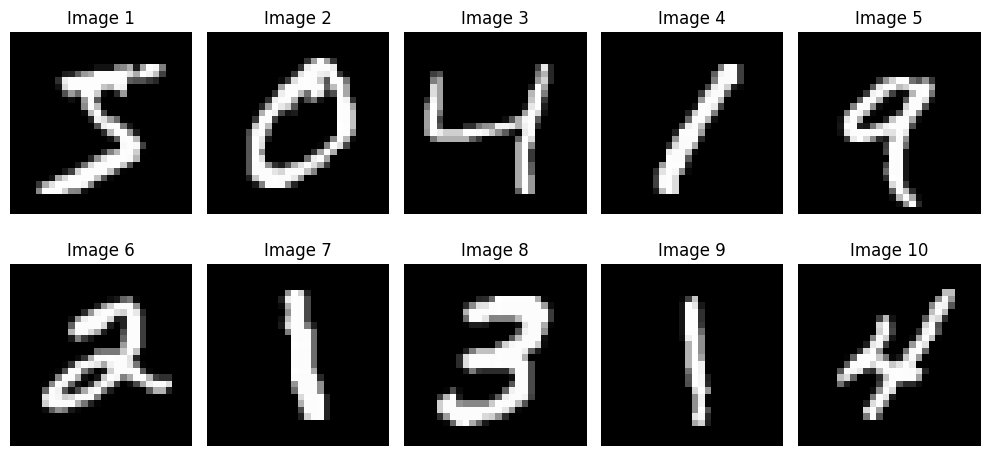

In [21]:
# Visualize the first few images in the dataset
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_images[i], cmap="gray")
    plt.title(f"Image {i + 1}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [9]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [10]:
# Create a TensorFlow dataset
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

In [11]:
# Generator
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh")
    ])
    return model

generator = build_generator()

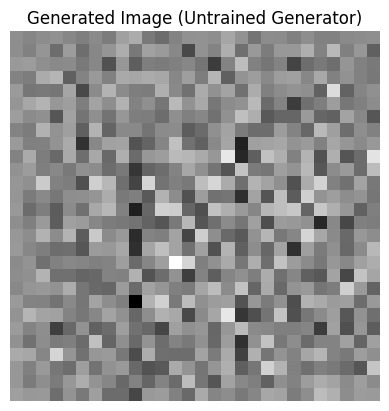

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         5

In [12]:
# Generate a random noise vector
noise = tf.random.normal([1, 100])

# Generate an image using the generator
generated_image = generator(noise, training=False)

# Plot the generated image
plt.imshow(generated_image[0, :, :, 0], cmap="gray")
plt.title("Generated Image (Untrained Generator)")
plt.axis("off")
plt.show()

# Print the Generator summary
generator.summary()

In [13]:
# Discriminator
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=(28, 28, 1)),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

discriminator = build_discriminator()

In [14]:
# Test the Discriminator with a sample input
decision = discriminator(generated_image, training=False)

# Print the discriminator's decision on the generated image
print("Discriminator's decision on generated image:", decision.numpy())

# Print the Discriminator summary
discriminator.summary()


Discriminator's decision on generated image: [[-0.00053429]]
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                           

In [15]:
# Define Binary Crossentropy as the loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)


In [16]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [17]:
def train(dataset, epochs):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        # Generate and visualize a batch of images after each epoch
        noise = tf.random.normal([16, 100])
        generated_images = generator(noise, training=False)

        plt.figure(figsize=(4, 4))
        for i in range(16):
            plt.subplot(4, 4, i + 1)
            plt.imshow(generated_images[i, :, :, 0] * 0.5 + 0.5, cmap="gray")
            plt.axis("off")
        plt.suptitle(f"Generated Images at Epoch {epoch + 1}")
        plt.show()

        print(f"Generator Loss: {gen_loss.numpy():.4f}, Discriminator Loss: {disc_loss.numpy():.4f}")

Training started...
Epoch 1/50


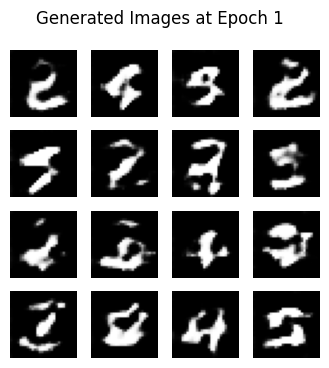

Generator Loss: 1.2895, Discriminator Loss: 0.8731
Epoch 2/50


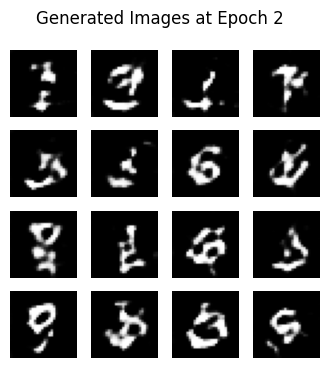

Generator Loss: 1.2911, Discriminator Loss: 1.0585
Epoch 3/50


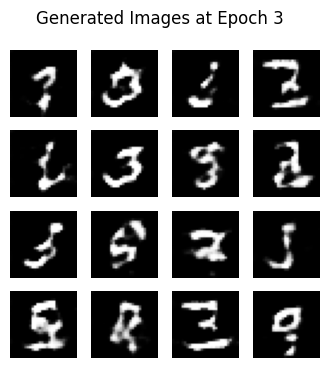

Generator Loss: 1.4081, Discriminator Loss: 0.8997
Epoch 4/50


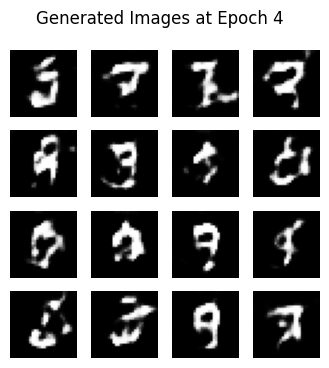

Generator Loss: 1.3095, Discriminator Loss: 0.8657
Epoch 5/50


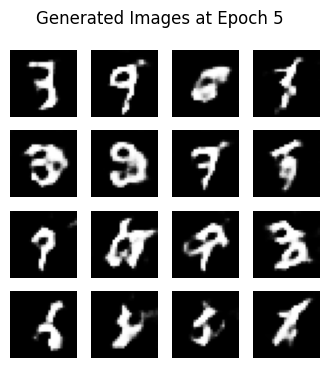

Generator Loss: 1.3083, Discriminator Loss: 1.0103
Epoch 6/50


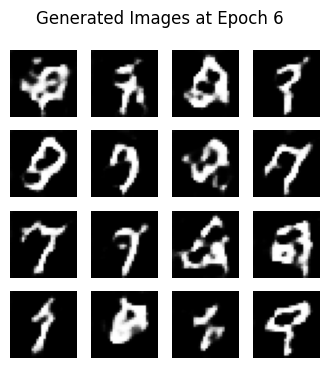

Generator Loss: 1.2650, Discriminator Loss: 1.0911
Epoch 7/50


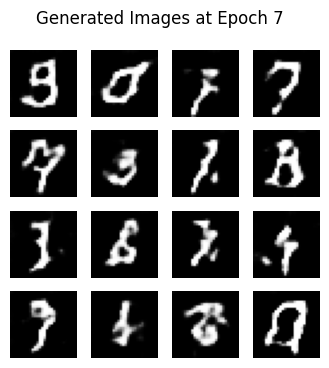

Generator Loss: 1.3197, Discriminator Loss: 1.0567
Epoch 8/50


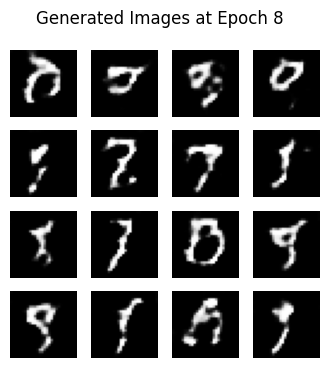

Generator Loss: 1.2996, Discriminator Loss: 1.1327
Epoch 9/50


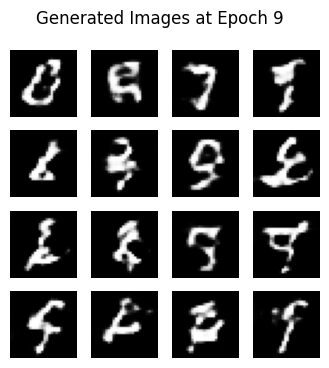

Generator Loss: 1.2222, Discriminator Loss: 0.9636
Epoch 10/50


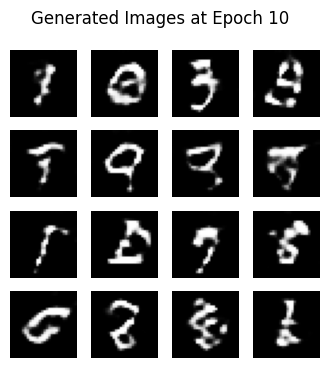

Generator Loss: 1.1846, Discriminator Loss: 1.0985
Epoch 11/50


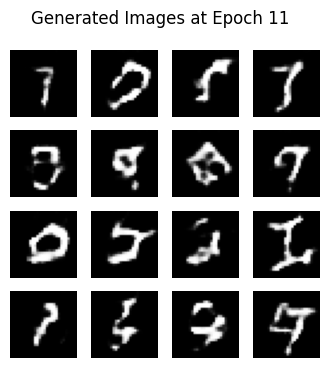

Generator Loss: 1.1547, Discriminator Loss: 1.1956
Epoch 12/50


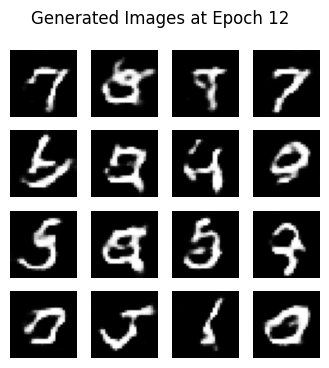

Generator Loss: 1.1077, Discriminator Loss: 1.0530
Epoch 13/50


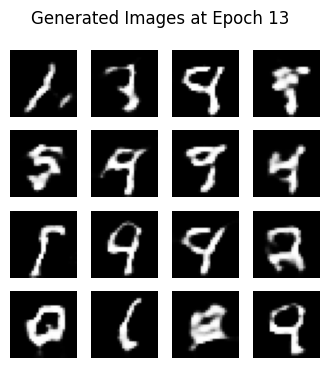

Generator Loss: 1.0148, Discriminator Loss: 1.1534
Epoch 14/50


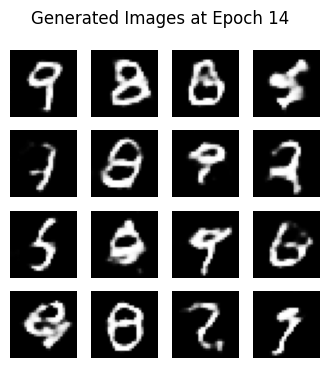

Generator Loss: 0.9263, Discriminator Loss: 1.3551
Epoch 15/50


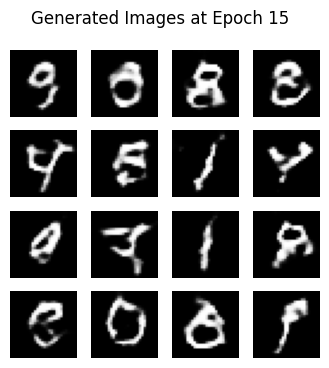

Generator Loss: 1.1158, Discriminator Loss: 1.1709
Epoch 16/50


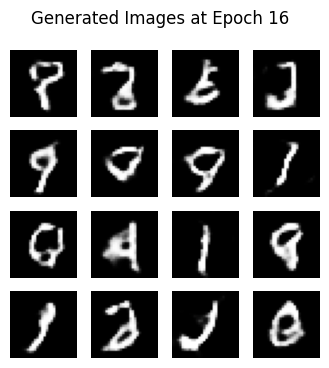

Generator Loss: 1.2170, Discriminator Loss: 1.0833
Epoch 17/50


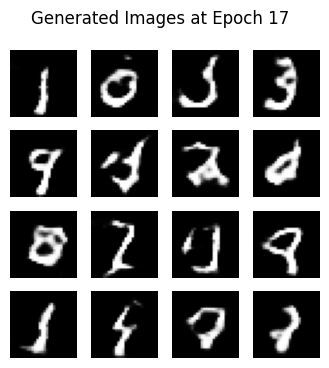

Generator Loss: 1.0178, Discriminator Loss: 1.1344
Epoch 18/50


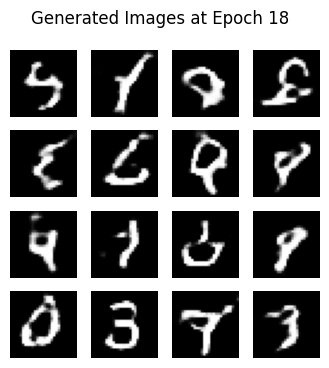

Generator Loss: 1.1410, Discriminator Loss: 1.1232
Epoch 19/50


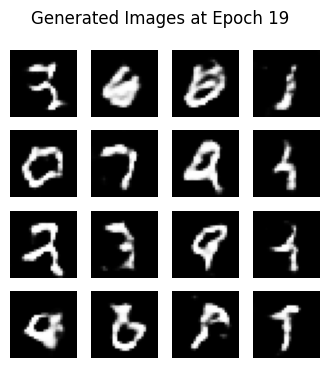

Generator Loss: 1.0375, Discriminator Loss: 1.2339
Epoch 20/50


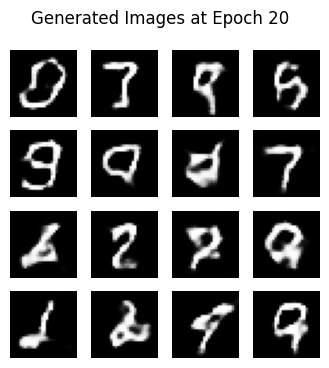

Generator Loss: 0.9801, Discriminator Loss: 1.2886
Epoch 21/50


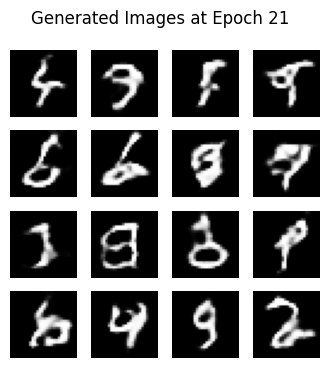

Generator Loss: 0.9771, Discriminator Loss: 1.2337
Epoch 22/50


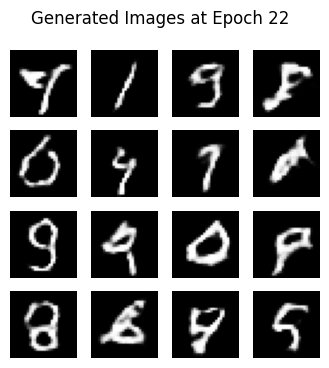

Generator Loss: 0.9324, Discriminator Loss: 1.2866
Epoch 23/50


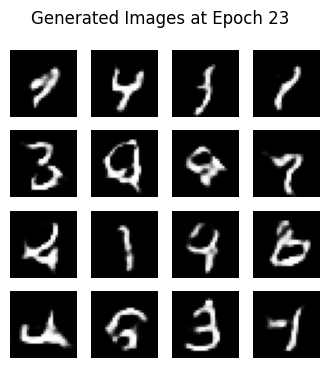

Generator Loss: 1.1188, Discriminator Loss: 1.0554
Epoch 24/50


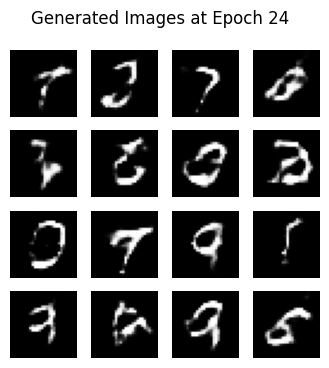

Generator Loss: 1.1177, Discriminator Loss: 1.1461
Epoch 25/50


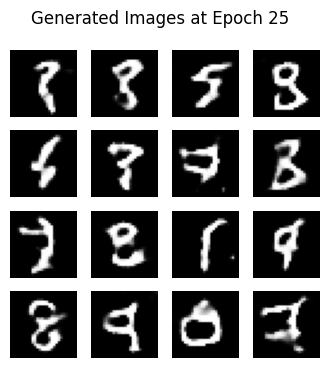

Generator Loss: 0.8630, Discriminator Loss: 1.2755
Epoch 26/50


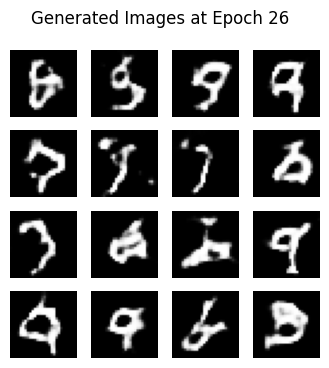

Generator Loss: 0.9489, Discriminator Loss: 1.2517
Epoch 27/50


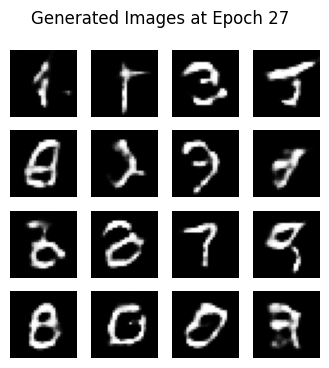

Generator Loss: 0.8752, Discriminator Loss: 1.3261
Epoch 28/50


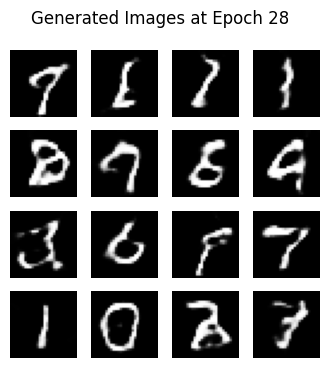

Generator Loss: 0.9558, Discriminator Loss: 1.1919
Epoch 29/50


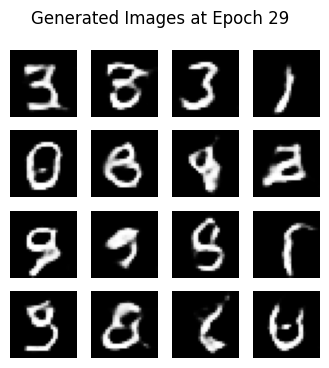

Generator Loss: 0.9238, Discriminator Loss: 1.3128
Epoch 30/50


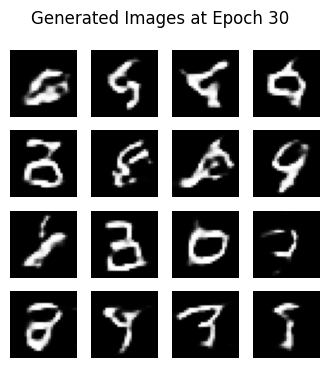

Generator Loss: 1.0784, Discriminator Loss: 1.1365
Epoch 31/50


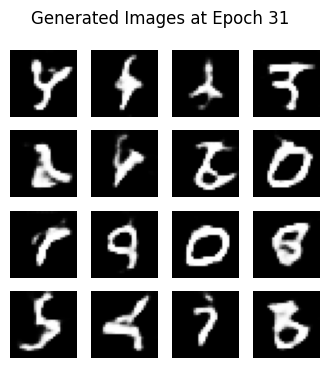

Generator Loss: 1.0390, Discriminator Loss: 1.1451
Epoch 32/50


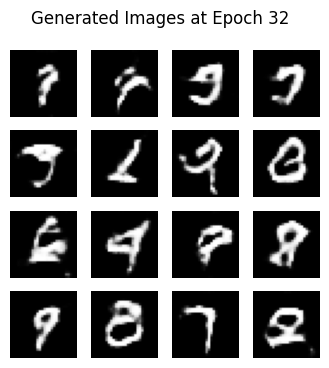

Generator Loss: 1.0936, Discriminator Loss: 1.1683
Epoch 33/50


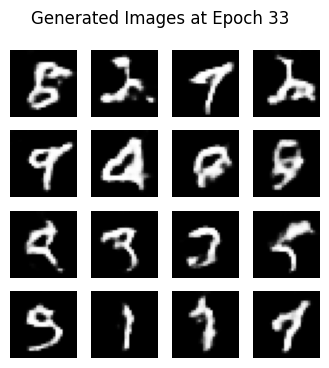

Generator Loss: 0.9566, Discriminator Loss: 1.2113
Epoch 34/50


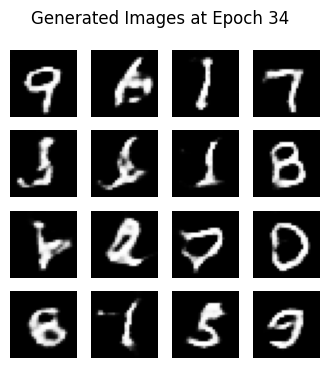

Generator Loss: 0.9145, Discriminator Loss: 1.2510
Epoch 35/50


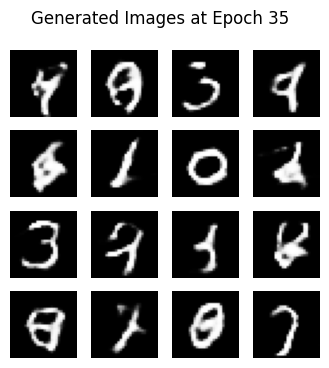

Generator Loss: 1.0386, Discriminator Loss: 1.1736
Epoch 36/50


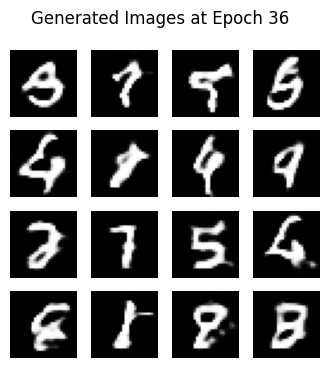

Generator Loss: 1.0077, Discriminator Loss: 1.0694
Epoch 37/50


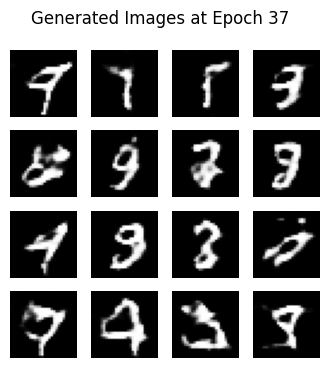

Generator Loss: 0.9284, Discriminator Loss: 1.3895
Epoch 38/50


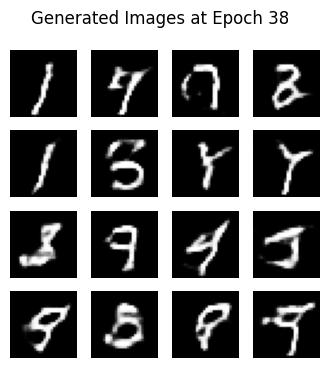

Generator Loss: 1.0338, Discriminator Loss: 1.1998
Epoch 39/50


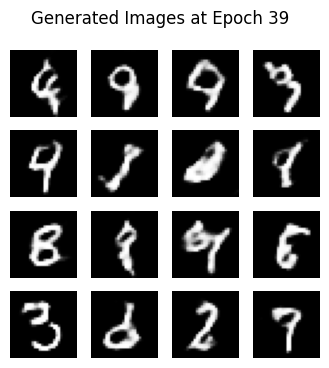

Generator Loss: 0.9235, Discriminator Loss: 1.2131
Epoch 40/50


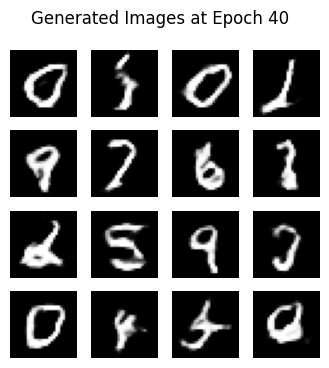

Generator Loss: 0.9529, Discriminator Loss: 1.0891
Epoch 41/50


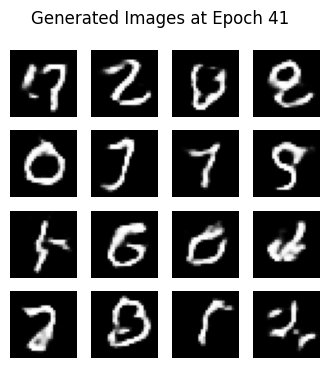

Generator Loss: 0.9826, Discriminator Loss: 1.2310
Epoch 42/50


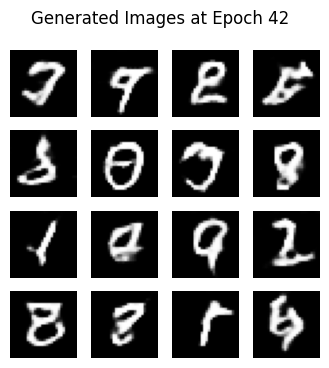

Generator Loss: 0.7952, Discriminator Loss: 1.4535
Epoch 43/50


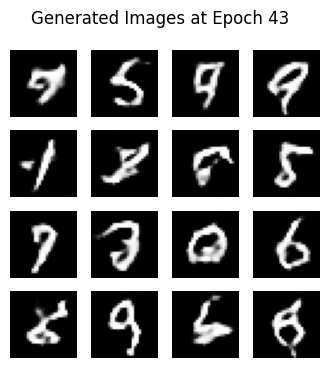

Generator Loss: 0.8272, Discriminator Loss: 1.3198
Epoch 44/50


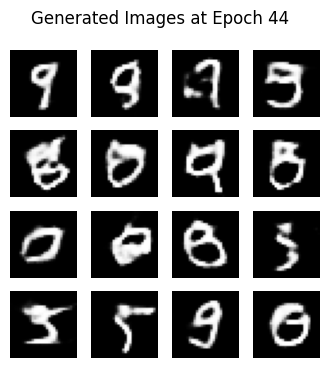

Generator Loss: 0.9021, Discriminator Loss: 1.1773
Epoch 45/50


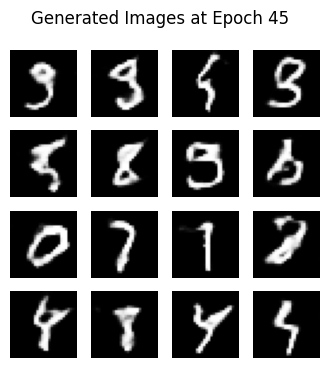

Generator Loss: 1.0629, Discriminator Loss: 1.0918
Epoch 46/50


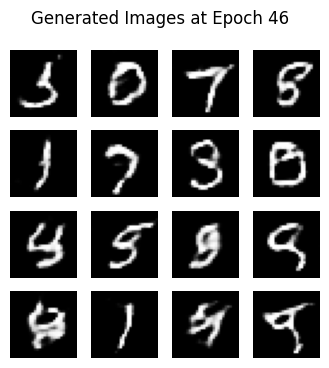

Generator Loss: 0.9756, Discriminator Loss: 1.2330
Epoch 47/50


AbortedError: Graph execution error:

Detected at node gradient_tape/sequential/conv2d_transpose/conv2d_transpose/Conv2DBackpropFilter defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Python311\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\Python311\Lib\site-packages\traitlets\config\application.py", line 1077, in launch_instance

  File "c:\Python311\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\Python311\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Python311\Lib\asyncio\base_events.py", line 604, in run_forever

  File "c:\Python311\Lib\asyncio\base_events.py", line 1909, in _run_once

  File "c:\Python311\Lib\asyncio\events.py", line 80, in _run

  File "c:\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 529, in dispatch_queue

  File "c:\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 518, in process_one

  File "c:\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 424, in dispatch_shell

  File "c:\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 766, in execute_request

  File "c:\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute

  File "c:\Python311\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\Nakul Limbani\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell

  File "C:\Users\Nakul Limbani\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell

  File "C:\Users\Nakul Limbani\AppData\Roaming\Python\Python311\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\Nakul Limbani\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async

  File "C:\Users\Nakul Limbani\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes

  File "C:\Users\Nakul Limbani\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code

  File "C:\Users\Nakul Limbani\AppData\Local\Temp\ipykernel_14152\3919638173.py", line 6, in <module>

  File "C:\Users\Nakul Limbani\AppData\Local\Temp\ipykernel_14152\1259696167.py", line 6, in train

  File "C:\Users\Nakul Limbani\AppData\Local\Temp\ipykernel_14152\2629927410.py", line 13, in train_step

Operation received an exception:Status: 1, message: could not create a memory object, in file tensorflow/core/kernels/mkl/mkl_conv_grad_filter_ops.cc:685
	 [[{{node gradient_tape/sequential/conv2d_transpose/conv2d_transpose/Conv2DBackpropFilter}}]] [Op:__inference_train_step_3250]

In [22]:
# Set the number of epochs
EPOCHS = 50

# Train the GAN
print("Training started...")
train(train_dataset, EPOCHS)
print("Training completed!")


In [19]:
# Save the Generator model
generator.save("generator_model.h5")
print("Generator model saved as 'generator_model.h5'")

# Save the Discriminator model
discriminator.save("discriminator_model.h5")
print("Discriminator model saved as 'discriminator_model.h5'")



Generator model saved as 'generator_model.h5'
Discriminator model saved as 'discriminator_model.h5'


c:\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


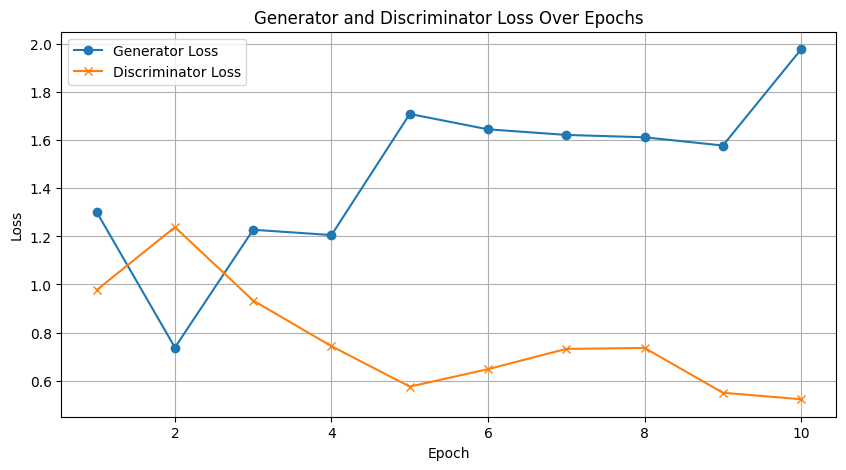

In [20]:
# Plot Generator and Discriminator Losses
gen_losses = [1.3018, 0.7377, 1.2277, 1.2055, 1.7094, 1.6454, 1.6222, 1.6123, 1.5780, 1.9787]
disc_losses = [0.9766, 1.2385, 0.9331, 0.7433, 0.5750, 0.6477, 0.7321, 0.7358, 0.5495, 0.5226]

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(gen_losses) + 1), gen_losses, label="Generator Loss", marker='o')
plt.plot(range(1, len(disc_losses) + 1), disc_losses, label="Discriminator Loss", marker='x')
plt.title("Generator and Discriminator Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()
